# Baseline Results for Pain Intensity Estimation (excl. No Pain class)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.utils import compute_class_weight
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import KFold
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras import Model

import sys
module_path = os.path.abspath(os.getcwd() + '\\..')
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data.load_dataset import load_dataset, get_class_names, load_fusioned_dataset
from src.lib.DeepStack.deepstack.base import KerasMember
from src.lib.DeepStack.deepstack.ensemble import DirichletEnsemble

In [2]:
epochs, batch_size = 50, 32
kf = KFold(n_splits=3, shuffle=True, random_state=42)

results = []

early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True,
    )

In [3]:
class Baseline():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(n_length, n_features))
        lstm = LSTM(50)(input)
        dense = Dense(50)(lstm)
        output = Dense(units=n_outputs, activation='softmax')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, class_weight=class_weight, verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

    def summary(self):
        self.model.summary()

## 1. Unimodal Body Modality (Skeleton)

### Dataset

In [4]:
X_train, X_test, y_train, y_test = load_dataset('skeleton', level=True, nopain=False)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[2], X_train.shape[3])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2], X_test.shape[3])
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[1], X_train.shape[-1], y_train.shape[1]

(380, 350, 35) (380, 3)
(235, 350, 35) (235, 3)


In [5]:
classes = get_class_names('skeleton', level=True, nopain=False)
tmp = pd.DataFrame(classes)
classes = tmp.value_counts()
classes

Mild        219
Moderate    158
Severe        3
dtype: int64

In [6]:
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 0.578386605783866, 1: 0.8016877637130801, 2: 42.22222222222222}

In [7]:
model = Baseline(n_features, n_length, n_outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 350, 35)]         0         
                                                                 
 lstm (LSTM)                 (None, 50)                17200     
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
 dense_1 (Dense)             (None, 3)                 153       
                                                                 
Total params: 19,903
Trainable params: 19,903
Non-trainable params: 0
_________________________________________________________________


### Baseline Model

Epoch 1/50
8/8 - 4s - loss: 1.5413 - accuracy: 0.5652 - auc_1: 0.7905 - precision_1: 0.6126 - recall_1: 0.4625 - f1_score: 0.2407 - val_loss: 0.8211 - val_accuracy: 0.5906 - val_auc_1: 0.8190 - val_precision_1: 0.6190 - val_recall_1: 0.4094 - val_f1_score: 0.2475 - 4s/epoch - 439ms/step
Epoch 2/50
8/8 - 1s - loss: 1.4919 - accuracy: 0.5652 - auc_1: 0.7891 - precision_1: 0.6056 - recall_1: 0.3399 - f1_score: 0.2407 - val_loss: 0.8210 - val_accuracy: 0.5984 - val_auc_1: 0.8211 - val_precision_1: 0.6721 - val_recall_1: 0.3228 - val_f1_score: 0.2721 - 734ms/epoch - 92ms/step
Epoch 3/50
8/8 - 1s - loss: 1.4537 - accuracy: 0.5731 - auc_1: 0.7917 - precision_1: 0.6126 - recall_1: 0.2688 - f1_score: 0.2600 - val_loss: 0.8249 - val_accuracy: 0.6142 - val_auc_1: 0.8248 - val_precision_1: 0.6727 - val_recall_1: 0.2913 - val_f1_score: 0.3061 - 683ms/epoch - 85ms/step
Epoch 4/50
8/8 - 1s - loss: 1.4350 - accuracy: 0.5771 - auc_1: 0.7922 - precision_1: 0.6038 - recall_1: 0.2530 - f1_score: 0.3081 - 

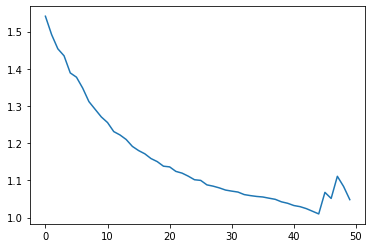

Epoch 1/50
8/8 - 4s - loss: 0.9505 - accuracy: 0.3320 - auc_2: 0.4558 - precision_2: 0.3333 - recall_2: 0.0079 - f1_score: 0.2568 - val_loss: 1.0972 - val_accuracy: 0.3858 - val_auc_2: 0.5454 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_f1_score: 0.2737 - 4s/epoch - 442ms/step
Epoch 2/50
8/8 - 1s - loss: 0.9052 - accuracy: 0.4545 - auc_2: 0.5943 - precision_2: 0.3333 - recall_2: 0.0040 - f1_score: 0.3260 - val_loss: 1.0367 - val_accuracy: 0.4882 - val_auc_2: 0.6580 - val_precision_2: 1.0000 - val_recall_2: 0.0157 - val_f1_score: 0.3239 - 649ms/epoch - 81ms/step
Epoch 3/50
8/8 - 1s - loss: 0.8605 - accuracy: 0.5494 - auc_2: 0.7066 - precision_2: 0.4167 - recall_2: 0.0198 - f1_score: 0.3716 - val_loss: 0.9924 - val_accuracy: 0.4961 - val_auc_2: 0.7146 - val_precision_2: 0.5556 - val_recall_2: 0.0394 - val_f1_score: 0.3264 - 653ms/epoch - 82ms/step
Epoch 4/50
8/8 - 1s - loss: 0.8425 - accuracy: 0.5534 - auc_2: 0.7504 - precision_2: 0.5000 - recall_2: 0.0632 - f1_score: 0

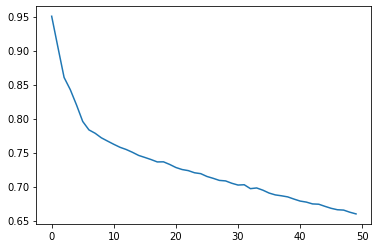

Epoch 1/50
8/8 - 3s - loss: 1.1046 - accuracy: 0.3543 - auc_3: 0.3857 - precision_3: 0.3448 - recall_3: 0.0394 - f1_score: 0.2080 - val_loss: 1.2033 - val_accuracy: 0.4286 - val_auc_3: 0.4667 - val_precision_3: 0.3529 - val_recall_3: 0.0476 - val_f1_score: 0.2164 - 3s/epoch - 343ms/step
Epoch 2/50
8/8 - 1s - loss: 1.0955 - accuracy: 0.3898 - auc_3: 0.4320 - precision_3: 0.3235 - recall_3: 0.0433 - f1_score: 0.2284 - val_loss: 1.1436 - val_accuracy: 0.4444 - val_auc_3: 0.5282 - val_precision_3: 0.4091 - val_recall_3: 0.0714 - val_f1_score: 0.2193 - 688ms/epoch - 86ms/step
Epoch 3/50
8/8 - 1s - loss: 1.0552 - accuracy: 0.3976 - auc_3: 0.4908 - precision_3: 0.2857 - recall_3: 0.0394 - f1_score: 0.2417 - val_loss: 1.1040 - val_accuracy: 0.4524 - val_auc_3: 0.5706 - val_precision_3: 0.4167 - val_recall_3: 0.0794 - val_f1_score: 0.2099 - 651ms/epoch - 81ms/step
Epoch 4/50
8/8 - 1s - loss: 1.0548 - accuracy: 0.4016 - auc_3: 0.5427 - precision_3: 0.3784 - recall_3: 0.0551 - f1_score: 0.2504 - 

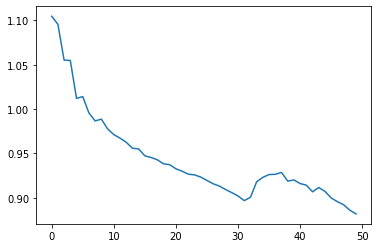

In [8]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    baseline_body_model = Baseline(n_features, n_length, n_outputs)
    history = baseline_body_model.train(X_train, y_train, X_val, y_val, epochs, batch_size, d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on holdout set

In [9]:
y_pred = baseline_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = baseline_body_model.evaluate(X_test, y_test)
results.append(round(auc, 2))
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 49.79% 
Balanced Accuracy: 23.59% 
ROC/AUC: 0.70 
Precision: 0.72 
Recall: 0.11 
F1 score: 0.25


## 2. Unimodal Face Modality (Action Units + Head Pose)

### Dataset

In [10]:
X_train, X_test, y_train, y_test = load_dataset('AUs', level=True, nopain=False)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[2], X_train.shape[3])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2], X_test.shape[3])
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[1], X_train.shape[-1], y_train.shape[1]

(366, 350, 25) (366, 3)
(231, 350, 25) (231, 3)


In [11]:
classes = get_class_names('AUs', level=True, nopain=False)
tmp = pd.DataFrame(classes)
classes = tmp.value_counts()
classes

Mild        211
Moderate    152
Severe        3
dtype: int64

In [12]:
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 0.5781990521327014, 1: 0.8026315789473685, 2: 40.666666666666664}

In [13]:
model = Baseline(n_features, n_length, n_outputs)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 350, 25)]         0         
                                                                 
 lstm_4 (LSTM)               (None, 50)                15200     
                                                                 
 dense_8 (Dense)             (None, 50)                2550      
                                                                 
 dense_9 (Dense)             (None, 3)                 153       
                                                                 
Total params: 17,903
Trainable params: 17,903
Non-trainable params: 0
_________________________________________________________________


### Baseline Model

Epoch 1/50
8/8 - 3s - loss: 1.3986 - accuracy: 0.2828 - auc_5: 0.4505 - precision_5: 0.3617 - recall_5: 0.0697 - f1_score: 0.1798 - val_loss: 1.2696 - val_accuracy: 0.2787 - val_auc_5: 0.4331 - val_precision_5: 0.1818 - val_recall_5: 0.0164 - val_f1_score: 0.1730 - 3s/epoch - 376ms/step
Epoch 2/50
8/8 - 1s - loss: 1.3729 - accuracy: 0.2746 - auc_5: 0.4290 - precision_5: 0.1053 - recall_5: 0.0082 - f1_score: 0.1758 - val_loss: 1.2583 - val_accuracy: 0.2787 - val_auc_5: 0.4222 - val_precision_5: 0.1111 - val_recall_5: 0.0082 - val_f1_score: 0.1717 - 645ms/epoch - 81ms/step
Epoch 3/50
8/8 - 1s - loss: 1.3517 - accuracy: 0.2951 - auc_5: 0.4217 - precision_5: 0.2143 - recall_5: 0.0123 - f1_score: 0.1851 - val_loss: 1.2468 - val_accuracy: 0.2787 - val_auc_5: 0.4174 - val_precision_5: 0.1111 - val_recall_5: 0.0082 - val_f1_score: 0.1717 - 654ms/epoch - 82ms/step
Epoch 4/50
8/8 - 1s - loss: 1.3324 - accuracy: 0.2992 - auc_5: 0.4255 - precision_5: 0.0909 - recall_5: 0.0041 - f1_score: 0.1870 - 

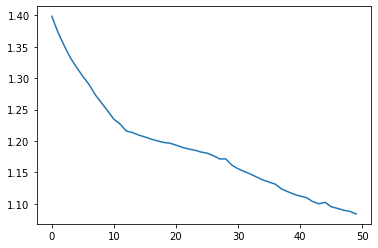

Epoch 1/50
8/8 - 3s - loss: 1.1233 - accuracy: 0.1025 - auc_6: 0.2997 - precision_6: 0.0173 - recall_6: 0.0123 - f1_score: 0.0926 - val_loss: 1.4076 - val_accuracy: 0.0984 - val_auc_6: 0.3204 - val_precision_6: 0.0625 - val_recall_6: 0.0410 - val_f1_score: 0.0899 - 3s/epoch - 338ms/step
Epoch 2/50
8/8 - 1s - loss: 1.0820 - accuracy: 0.1352 - auc_6: 0.3237 - precision_6: 0.0233 - recall_6: 0.0123 - f1_score: 0.1157 - val_loss: 1.3470 - val_accuracy: 0.1066 - val_auc_6: 0.3407 - val_precision_6: 0.1042 - val_recall_6: 0.0410 - val_f1_score: 0.0935 - 653ms/epoch - 82ms/step
Epoch 3/50
8/8 - 1s - loss: 1.0458 - accuracy: 0.1721 - auc_6: 0.3553 - precision_6: 0.0526 - recall_6: 0.0205 - f1_score: 0.1383 - val_loss: 1.2973 - val_accuracy: 0.1393 - val_auc_6: 0.3639 - val_precision_6: 0.1071 - val_recall_6: 0.0246 - val_f1_score: 0.1142 - 654ms/epoch - 82ms/step
Epoch 4/50
8/8 - 1s - loss: 1.0161 - accuracy: 0.2008 - auc_6: 0.3923 - precision_6: 0.1636 - recall_6: 0.0369 - f1_score: 0.1508 - 

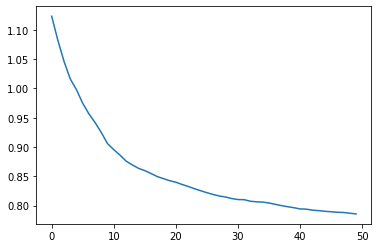

Epoch 1/50
8/8 - 3s - loss: 1.1668 - accuracy: 0.2172 - auc_7: 0.3954 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - f1_score: 0.1955 - val_loss: 1.1304 - val_accuracy: 0.3033 - val_auc_7: 0.4630 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_f1_score: 0.2659 - 3s/epoch - 338ms/step
Epoch 2/50
8/8 - 1s - loss: 1.1522 - accuracy: 0.2336 - auc_7: 0.4573 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - f1_score: 0.2048 - val_loss: 1.1206 - val_accuracy: 0.3115 - val_auc_7: 0.4826 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_f1_score: 0.2683 - 639ms/epoch - 80ms/step
Epoch 3/50
8/8 - 1s - loss: 1.1447 - accuracy: 0.3197 - auc_7: 0.4857 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - f1_score: 0.2647 - val_loss: 1.1143 - val_accuracy: 0.3197 - val_auc_7: 0.4886 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_f1_score: 0.2703 - 644ms/epoch - 81ms/step
Epoch 4/50
8/8 - 1s - loss: 1.1393 - accuracy: 0.3361 - auc_7: 0.5079 - precision_7:

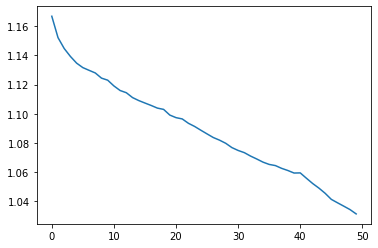

In [14]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    baseline_face_model = Baseline(n_features, n_length, n_outputs)
    history = baseline_face_model.train(X_train, y_train, X_val, y_val, epochs, batch_size, d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [15]:
y_pred = baseline_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = baseline_face_model.evaluate(X_test, y_test)
results.append(round(acc, 2))
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 41.13% 
Balanced Accuracy: 49.52% 
ROC/AUC: 0.71 
Precision: 1.00 
Recall: 0.00 
F1 score: 0.30


## 3. Multimodal Early Fusion

### Dataset

In [16]:
X_train, X_test, y_train, y_test = load_fusioned_dataset(level=True, nopain=False)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[2], X_train.shape[3])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2], X_test.shape[3])
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[1], X_train.shape[-1], y_train.shape[1]

(366, 350, 60) (366, 3)
(231, 350, 60) (231, 3)


In [17]:
model = Baseline(n_features, n_length, n_outputs)
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 350, 60)]         0         
                                                                 
 lstm_8 (LSTM)               (None, 50)                22200     
                                                                 
 dense_16 (Dense)            (None, 50)                2550      
                                                                 
 dense_17 (Dense)            (None, 3)                 153       
                                                                 
Total params: 24,903
Trainable params: 24,903
Non-trainable params: 0
_________________________________________________________________


### Baseline Model

Epoch 1/50
8/8 - 3s - loss: 1.4770 - accuracy: 0.0902 - auc_9: 0.3129 - precision_9: 0.0586 - recall_9: 0.0533 - f1_score: 0.0863 - val_loss: 1.5467 - val_accuracy: 0.0738 - val_auc_9: 0.3308 - val_precision_9: 0.0374 - val_recall_9: 0.0328 - val_f1_score: 0.0690 - 3s/epoch - 339ms/step
Epoch 2/50
8/8 - 1s - loss: 1.4345 - accuracy: 0.1148 - auc_9: 0.3282 - precision_9: 0.0769 - recall_9: 0.0697 - f1_score: 0.1079 - val_loss: 1.5014 - val_accuracy: 0.0738 - val_auc_9: 0.3445 - val_precision_9: 0.0467 - val_recall_9: 0.0410 - val_f1_score: 0.0674 - 667ms/epoch - 83ms/step
Epoch 3/50
8/8 - 1s - loss: 1.3976 - accuracy: 0.1230 - auc_9: 0.3399 - precision_9: 0.0833 - recall_9: 0.0738 - f1_score: 0.1141 - val_loss: 1.4529 - val_accuracy: 0.0820 - val_auc_9: 0.3521 - val_precision_9: 0.0490 - val_recall_9: 0.0410 - val_f1_score: 0.0741 - 653ms/epoch - 82ms/step
Epoch 4/50
8/8 - 1s - loss: 1.3635 - accuracy: 0.1311 - auc_9: 0.3426 - precision_9: 0.0891 - recall_9: 0.0738 - f1_score: 0.1195 - 

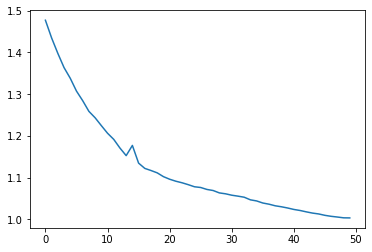

Epoch 1/50
8/8 - 3s - loss: 0.9214 - accuracy: 0.2664 - auc_10: 0.4324 - precision_10: 0.3333 - recall_10: 0.0123 - f1_score: 0.2118 - val_loss: 1.1550 - val_accuracy: 0.2541 - val_auc_10: 0.4269 - val_precision_10: 0.2500 - val_recall_10: 0.0082 - val_f1_score: 0.2119 - 3s/epoch - 346ms/step
Epoch 2/50
8/8 - 1s - loss: 0.8963 - accuracy: 0.3361 - auc_10: 0.5144 - precision_10: 0.7500 - recall_10: 0.0123 - f1_score: 0.2511 - val_loss: 1.1294 - val_accuracy: 0.2705 - val_auc_10: 0.4749 - val_precision_10: 0.3333 - val_recall_10: 0.0082 - val_f1_score: 0.2177 - 654ms/epoch - 82ms/step
Epoch 3/50
8/8 - 1s - loss: 0.8806 - accuracy: 0.3648 - auc_10: 0.5617 - precision_10: 1.0000 - recall_10: 0.0164 - f1_score: 0.2759 - val_loss: 1.1147 - val_accuracy: 0.3197 - val_auc_10: 0.5046 - val_precision_10: 0.5000 - val_recall_10: 0.0082 - val_f1_score: 0.2460 - 655ms/epoch - 82ms/step
Epoch 4/50
8/8 - 1s - loss: 0.8679 - accuracy: 0.4139 - auc_10: 0.5996 - precision_10: 1.0000 - recall_10: 0.0246 

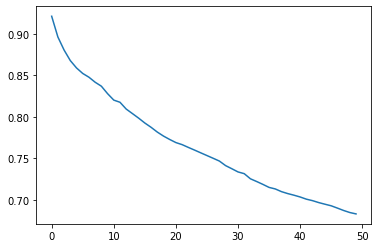

Epoch 1/50
8/8 - 3s - loss: 1.1316 - accuracy: 0.1721 - auc_11: 0.4157 - precision_11: 0.2857 - recall_11: 0.0984 - f1_score: 0.1322 - val_loss: 1.2572 - val_accuracy: 0.1721 - val_auc_11: 0.3802 - val_precision_11: 0.1765 - val_recall_11: 0.0492 - val_f1_score: 0.1407 - 3s/epoch - 380ms/step
Epoch 2/50
8/8 - 1s - loss: 1.1141 - accuracy: 0.1844 - auc_11: 0.4374 - precision_11: 0.3906 - recall_11: 0.1025 - f1_score: 0.1410 - val_loss: 1.2238 - val_accuracy: 0.1803 - val_auc_11: 0.4036 - val_precision_11: 0.2500 - val_recall_11: 0.0574 - val_f1_score: 0.1448 - 655ms/epoch - 82ms/step
Epoch 3/50
8/8 - 1s - loss: 1.1178 - accuracy: 0.1967 - auc_11: 0.4628 - precision_11: 0.4386 - recall_11: 0.1025 - f1_score: 0.1451 - val_loss: 1.1997 - val_accuracy: 0.1803 - val_auc_11: 0.4256 - val_precision_11: 0.3478 - val_recall_11: 0.0656 - val_f1_score: 0.1448 - 697ms/epoch - 87ms/step
Epoch 4/50
8/8 - 1s - loss: 1.0871 - accuracy: 0.2008 - auc_11: 0.4673 - precision_11: 0.4808 - recall_11: 0.1025 

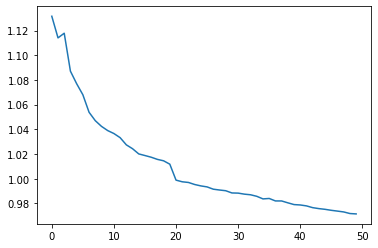

In [18]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = Baseline(n_features, n_length, n_outputs)
    history = model.train(X_train, y_train, X_val, y_val, epochs, batch_size, d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [19]:
y_pred = model.predict(X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(X_test, y_test)
results.append(round(acc, 2))
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 30.30% 
Balanced Accuracy: 38.46% 
ROC/AUC: 0.54 
Precision: 0.37 
Recall: 0.06 
F1 score: 0.23


## 4. Multimodal Late Fusion

### Dataset

In [20]:
body_X_train, body_X_test, body_y_train, body_y_test = load_dataset('skeleton', fusion=True, level=True, nopain=False)
body_X_train = body_X_train.reshape(body_X_train.shape[0], body_X_train.shape[2], body_X_train.shape[3])
body_X_test = body_X_test.reshape(body_X_test.shape[0], body_X_test.shape[2], body_X_test.shape[3])
body_X = body_X_train.copy()
body_y = body_y_train.copy()

print(body_X_train.shape, body_y_train.shape)
print(body_X_test.shape, body_y_test.shape)

(366, 350, 35) (366, 3)
(231, 350, 35) (231, 3)


In [21]:
face_X_train, face_X_test, face_y_train, face_y_test = load_dataset('AUs', level=True, nopain=False)
face_X_train = face_X_train.reshape(face_X_train.shape[0], face_X_train.shape[2], face_X_train.shape[3])
face_X_test = face_X_test.reshape(face_X_test.shape[0], face_X_test.shape[2], face_X_test.shape[3])
face_X = face_X_train.copy()
face_y = face_y_train.copy()

print(face_X_train.shape, face_y_train.shape)
print(face_X_test.shape, face_y_test.shape)

(366, 350, 25) (366, 3)
(231, 350, 25) (231, 3)


In [22]:
n_length, body_features, face_features, n_outputs = face_X_train.shape[1], body_X_train.shape[-1], face_X_train.shape[-1], body_y_train.shape[1]

### Baseline Model

In [26]:
class fusioned_Baseline():
    def __init__(self, body_features, face_features, n_length, n_outputs):
        input_1 = Input(shape=(n_length, body_features))
        lstm_1 = LSTM(50)(input_1)
        dense_1 = Dense(50)(lstm_1)

        input_2 = Input(shape=(n_length, face_features))
        lstm_2 = LSTM(50)(input_2)
        dense_2 = Dense(50)(lstm_2)

        concat = Concatenate()([dense_1, dense_2])
        output = Dense(units=n_outputs, activation='softmax')(concat)
        model = Model(inputs=[input_1, input_2], outputs=[output])
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit([body_X_train, face_X_train], y_train, validation_data=([body_X_val, face_X_val], y_val), 
                            epochs=epochs, batch_size=batch_size, class_weight=class_weight, verbose=2)
        return history

    def evaluate(self, body_X_test, face_X_test, y_test):
        results = self.model.evaluate([body_X_test, face_X_test], y_test, verbose=0)
        return results

    def predict(self, body_X_test, face_X_test):
        predictions = self.model.predict([body_X_test, face_X_test])
        return predictions

    def summary(self):
        self.model.summary()

In [27]:
model = fusioned_Baseline(body_features, face_features, n_length, n_outputs)
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 350, 35)]    0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 350, 25)]    0           []                               
                                                                                                  
 lstm_16 (LSTM)                 (None, 50)           17200       ['input_17[0][0]']               
                                                                                                  
 lstm_17 (LSTM)                 (None, 50)           15200       ['input_18[0][0]']               
                                                                                           

### Baseline Model

Epoch 1/50
8/8 - 6s - loss: 1.9165 - accuracy: 0.5164 - auc_15: 0.7752 - precision_15: 0.5604 - recall_15: 0.4754 - f1_score: 0.2321 - val_loss: 0.7514 - val_accuracy: 0.5984 - val_auc_15: 0.8076 - val_precision_15: 0.5943 - val_recall_15: 0.5164 - val_f1_score: 0.2928 - 6s/epoch - 742ms/step
Epoch 2/50
8/8 - 1s - loss: 1.8500 - accuracy: 0.5369 - auc_15: 0.7786 - precision_15: 0.5641 - recall_15: 0.4508 - f1_score: 0.2785 - val_loss: 0.7591 - val_accuracy: 0.5984 - val_auc_15: 0.8026 - val_precision_15: 0.6040 - val_recall_15: 0.5000 - val_f1_score: 0.3097 - 858ms/epoch - 107ms/step
Epoch 3/50
8/8 - 1s - loss: 1.7855 - accuracy: 0.5369 - auc_15: 0.7812 - precision_15: 0.5450 - recall_15: 0.4221 - f1_score: 0.2924 - val_loss: 0.7670 - val_accuracy: 0.5656 - val_auc_15: 0.7945 - val_precision_15: 0.5652 - val_recall_15: 0.4262 - val_f1_score: 0.3097 - 877ms/epoch - 110ms/step
Epoch 4/50
8/8 - 1s - loss: 1.7268 - accuracy: 0.5615 - auc_15: 0.7857 - precision_15: 0.5574 - recall_15: 0.418

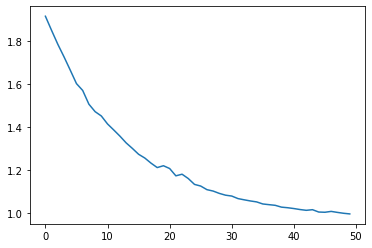

Epoch 1/50
8/8 - 4s - loss: 0.9474 - accuracy: 0.3893 - auc_16: 0.4258 - precision_16: 0.5000 - recall_16: 0.0041 - f1_score: 0.2297 - val_loss: 1.1684 - val_accuracy: 0.4098 - val_auc_16: 0.4537 - val_precision_16: 0.0000e+00 - val_recall_16: 0.0000e+00 - val_f1_score: 0.2424 - 4s/epoch - 509ms/step
Epoch 2/50
8/8 - 1s - loss: 0.9215 - accuracy: 0.4139 - auc_16: 0.5055 - precision_16: 1.0000 - recall_16: 0.0041 - f1_score: 0.2529 - val_loss: 1.1177 - val_accuracy: 0.4344 - val_auc_16: 0.5379 - val_precision_16: 0.0000e+00 - val_recall_16: 0.0000e+00 - val_f1_score: 0.2623 - 839ms/epoch - 105ms/step
Epoch 3/50
8/8 - 1s - loss: 0.8952 - accuracy: 0.4303 - auc_16: 0.5818 - precision_16: 1.0000 - recall_16: 0.0123 - f1_score: 0.2617 - val_loss: 1.1016 - val_accuracy: 0.4344 - val_auc_16: 0.5675 - val_precision_16: 0.0000e+00 - val_recall_16: 0.0000e+00 - val_f1_score: 0.2703 - 853ms/epoch - 107ms/step
Epoch 4/50
8/8 - 1s - loss: 0.8797 - accuracy: 0.4713 - auc_16: 0.6286 - precision_16: 1

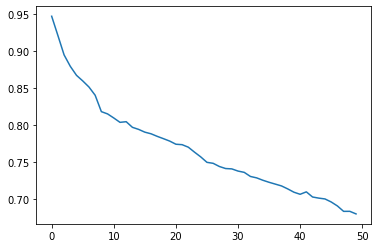

Epoch 1/50
8/8 - 5s - loss: 1.1871 - accuracy: 0.4754 - auc_17: 0.7397 - precision_17: 0.5268 - recall_17: 0.2418 - f1_score: 0.3121 - val_loss: 0.9509 - val_accuracy: 0.3934 - val_auc_17: 0.7018 - val_precision_17: 0.4510 - val_recall_17: 0.1885 - val_f1_score: 0.2542 - 5s/epoch - 602ms/step
Epoch 2/50
8/8 - 1s - loss: 1.1660 - accuracy: 0.4959 - auc_17: 0.7538 - precision_17: 0.5729 - recall_17: 0.2254 - f1_score: 0.3271 - val_loss: 0.9589 - val_accuracy: 0.4508 - val_auc_17: 0.6965 - val_precision_17: 0.4091 - val_recall_17: 0.1475 - val_f1_score: 0.2987 - 847ms/epoch - 106ms/step
Epoch 3/50
8/8 - 1s - loss: 1.1385 - accuracy: 0.5164 - auc_17: 0.7608 - precision_17: 0.6071 - recall_17: 0.2090 - f1_score: 0.3450 - val_loss: 0.9600 - val_accuracy: 0.4508 - val_auc_17: 0.6989 - val_precision_17: 0.4250 - val_recall_17: 0.1393 - val_f1_score: 0.3018 - 855ms/epoch - 107ms/step
Epoch 4/50
8/8 - 1s - loss: 1.1112 - accuracy: 0.5287 - auc_17: 0.7682 - precision_17: 0.6329 - recall_17: 0.204

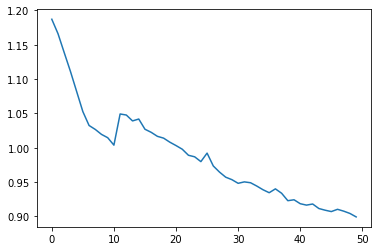

In [28]:
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    body_y_train, body_y_val = body_y[train_index], body_y[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    face_y_train, face_y_val = face_y[train_index], face_y[val_index]
    model = fusioned_Baseline(body_features, face_features, n_length, n_outputs)
    history = model.train(body_X_train, face_X_train, body_y_train, body_X_val, face_X_val, face_y_val, epochs, batch_size, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [29]:
y_pred = model.predict(body_X_test, face_X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(body_X_test, face_X_test, body_y_test)
results.append(round(auc, 2))
bal_acc = balanced_accuracy_score(body_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 44.59% 
Balanced Accuracy: 46.64% 
ROC/AUC: 0.64 
Precision: 0.66 
Recall: 0.09 
F1 score: 0.31


### Ensemble

In [30]:
baseline_body_member = KerasMember(name="Body Model", keras_model=baseline_body_model, train_batches=(body_X_train, y_train), val_batches=(body_X_test, body_y_test))
baseline_face_member = KerasMember(name="Face Model", keras_model=baseline_face_model, train_batches=(face_X_train, face_y_train), val_batches=(face_X_test, face_y_test))

In [31]:
dirichletEnsemble = DirichletEnsemble()
dirichletEnsemble.add_member(baseline_body_member)
dirichletEnsemble.add_member(baseline_face_member)
dirichletEnsemble.fit()

In [32]:
e = dirichletEnsemble.describe()
results.append(round(e, 2))

Body Model (weight: 0.0004)
Face Model (weight: 0.9996)
Accuracy: 56.71% - ROC/AUC: 0.56 - Precision: 0.39 - Recall: 0.53 - F1 score: 0.39


## Results

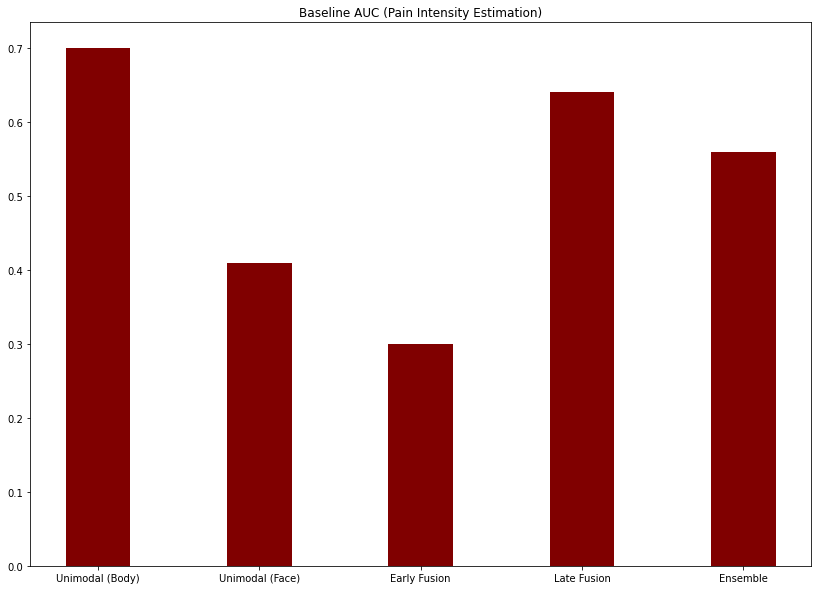

In [33]:
data = {'Unimodal (Body)':results[0], 'Unimodal (Face)':results[1], 'Early Fusion':results[2],
        'Late Fusion':results[3], 'Ensemble':results[4]}
models = list(data.keys())
performance = list(data.values())
  
fig = plt.figure(figsize = (14, 10))
 
plt.bar(models, performance, color ='maroon',
        width = 0.4)
 
plt.title("Baseline AUC (Pain Intensity Estimation)")
plt.show()